In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import torch
import seaborn as sns

from numpy.random import dirichlet
from scipy.stats import spearmanr, pearsonr
from torch.nn.functional import softmax


sns.set_theme(font="serif")

In [2]:
# parameters
alpha = 0.1
domain_size = 1000
scaling = 42
noise = 0.42
seed = 42

# sampling
num_corpora = 1000
num_per_corpus = 100_000
num_bins = 10
num_corpora_per_bin = num_corpora // num_bins

# typicality
epsilon = 0.001

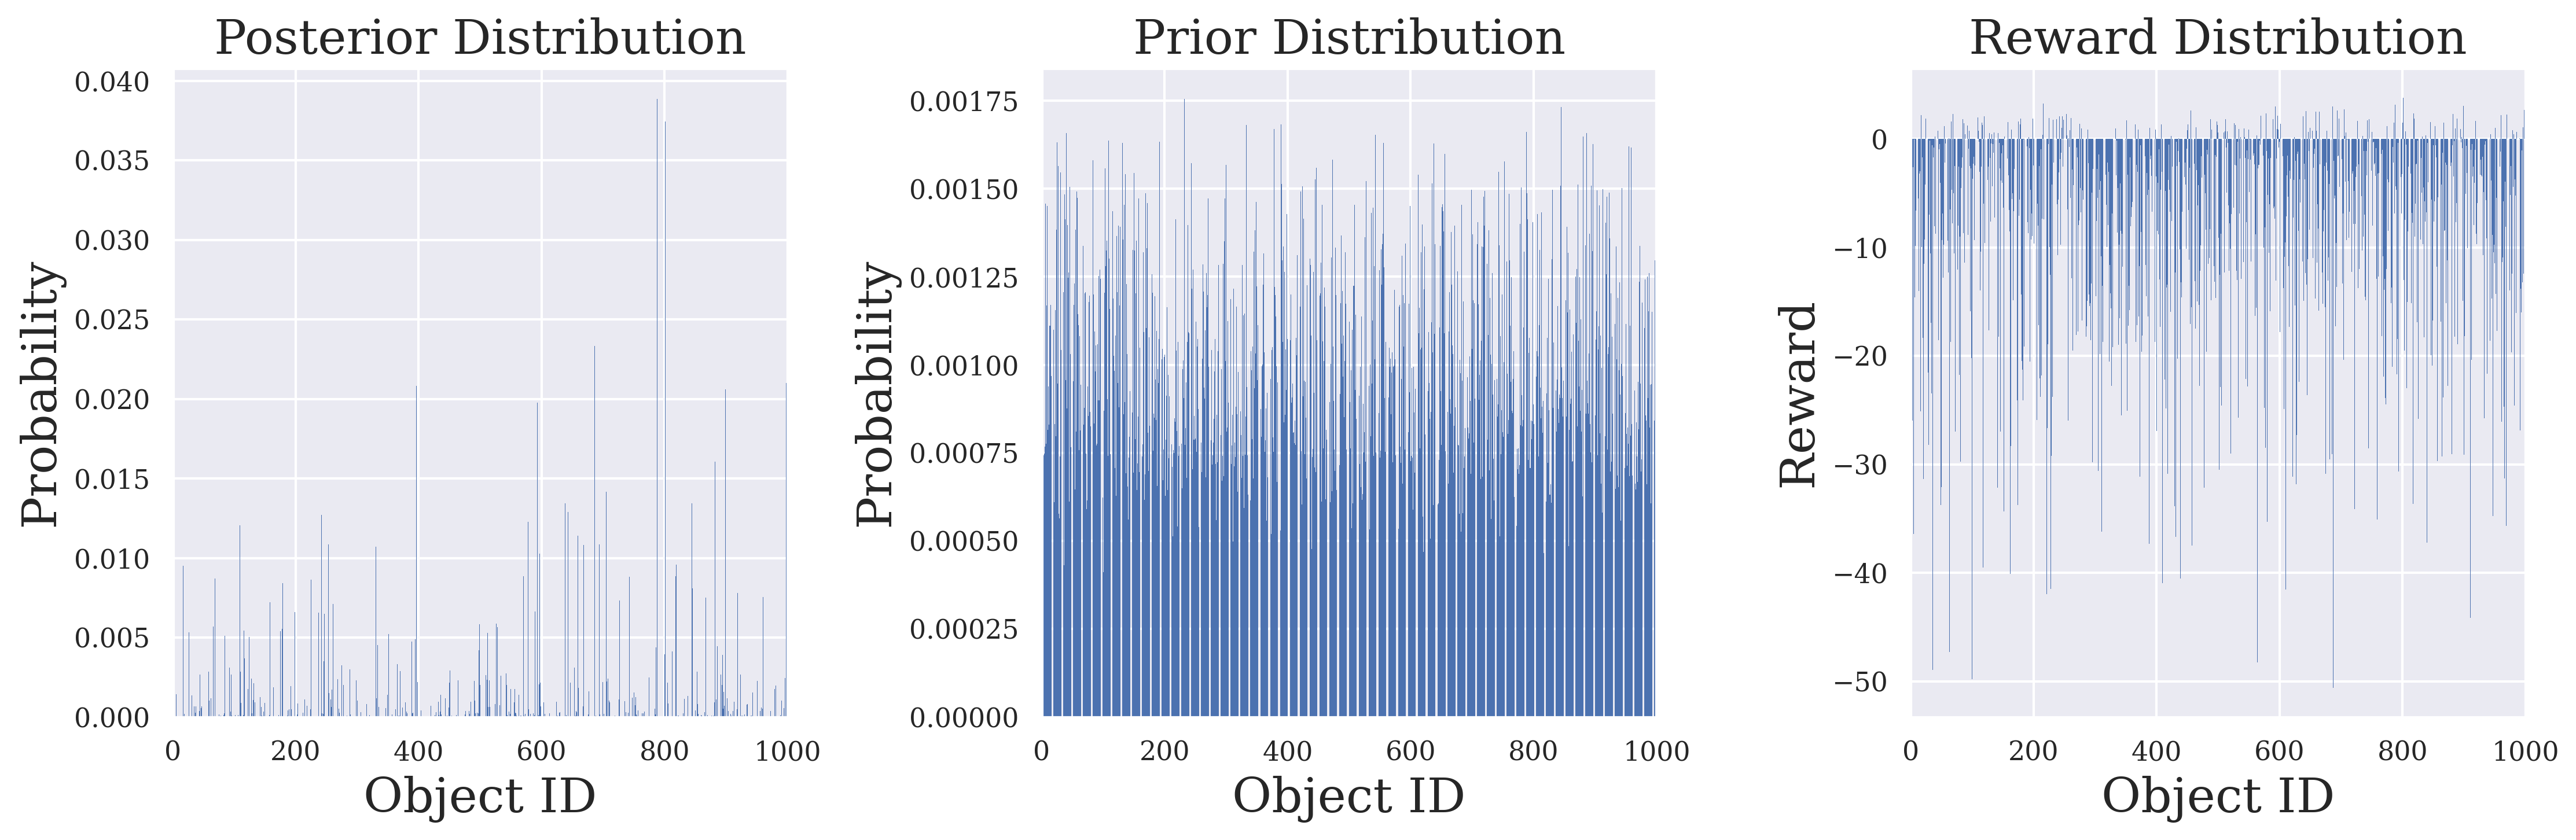

Joint Entropy: 5.01, Prior Entropy: 6.87


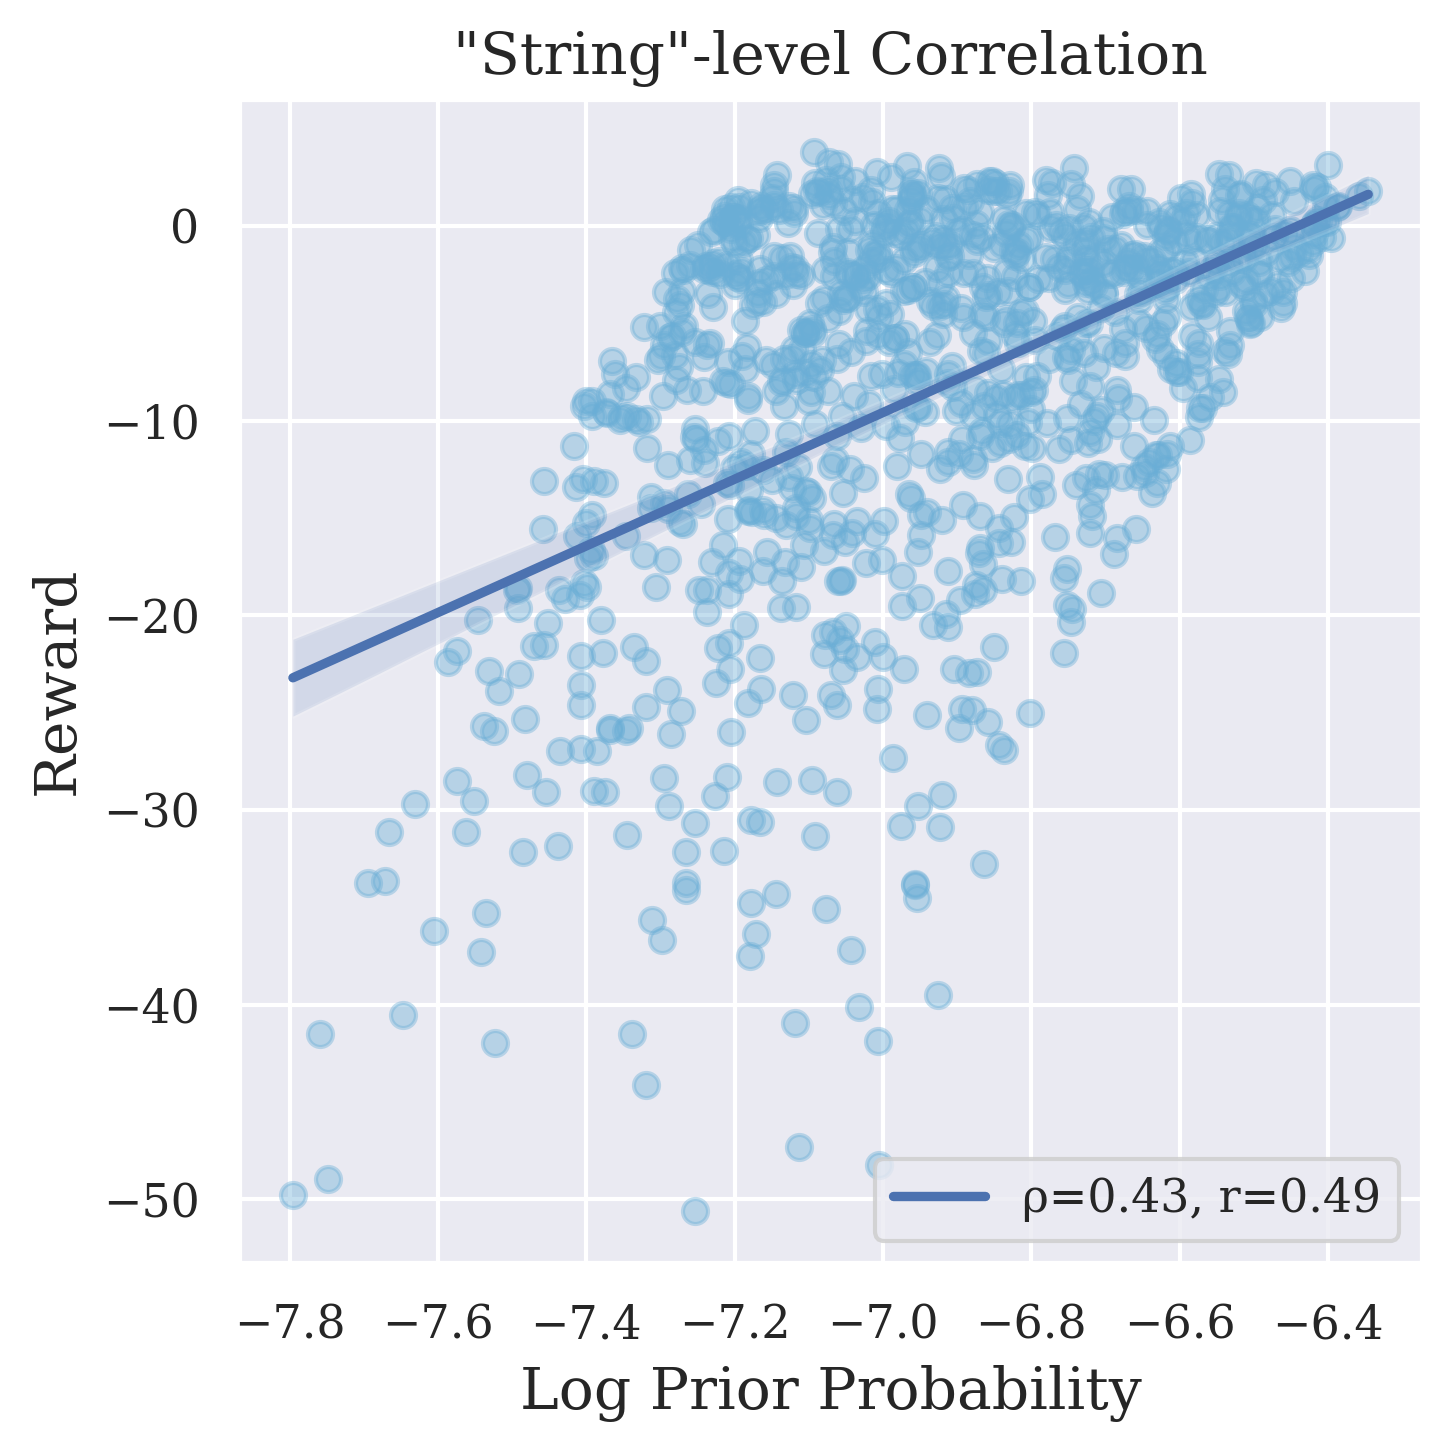

Typical Corpora: 213/1000


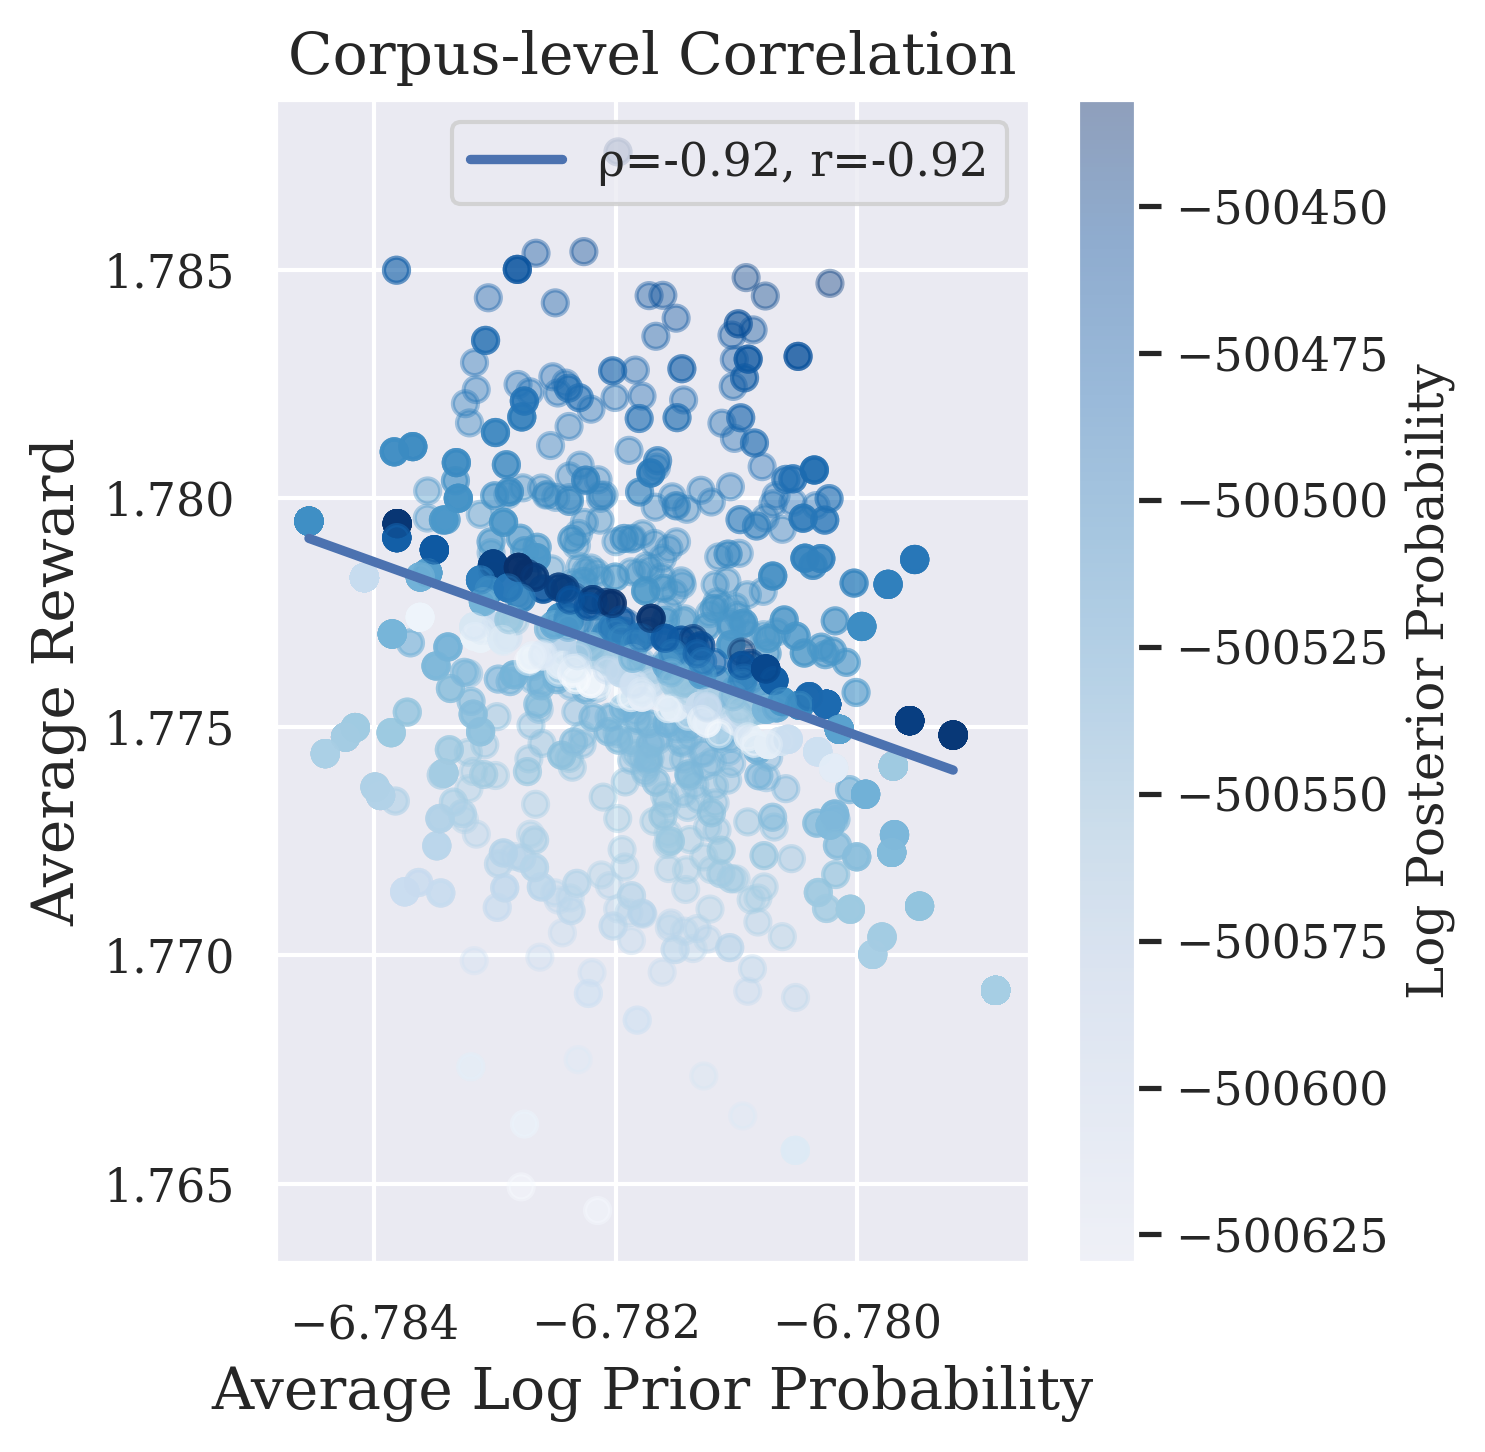

In [7]:
# 1. create p(y|A=+), p(y) and r(y), such that p(y) and r(y) are correlated
np.random.seed(seed)
p_y_A = dirichlet(alpha=[alpha] * domain_size, size=1).flatten()
p_y = softmax(
    torch.from_numpy(p_y_A) ** (1 / scaling)
    + np.random.uniform(-noise, noise, size=domain_size),
    dim=0,
).numpy()
reward = np.log(p_y_A / p_y)
assert np.allclose(np.sum(p_y_A), 1)
assert np.allclose(np.sum(p_y), 1)
assert np.all(p_y_A > 0)
assert np.all(p_y > 0)

# 1.1 plot
fig, ax = plt.subplots(1, 3, figsize=(15, 5), dpi=300)
ax[0].bar(range(domain_size), p_y_A, edgecolor="none")
ax[0].set_title("Posterior Distribution", fontsize=20)
ax[0].set_ylabel("Probability", fontsize=20)

ax[1].bar(range(domain_size), p_y, edgecolor="none")
ax[1].set_title("Prior Distribution", fontsize=20)
ax[1].set_ylabel("Probability", fontsize=20)


ax[2].bar(range(domain_size), reward, edgecolor="none")
ax[2].set_title("Reward Distribution", fontsize=20)
ax[2].set_ylabel("Reward", fontsize=20)

for a in ax:
    a.set_xlabel("Object ID", fontsize=20)
    a.set_xlim(0, domain_size)

plt.tight_layout()
plt.savefig("toy-distributions.png", format="png")
plt.show()
plt.close()


# 2. compute
entropy = -np.sum(p_y_A * np.log(p_y_A))
prior_entropy = -np.sum(p_y * np.log(p_y))
print(f"Joint Entropy: {entropy:.2f}, Prior Entropy: {prior_entropy:.2f}")

# 3. plot correlation between log p(y) and r(y)
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
log_p_y = np.log(p_y)
spearman = spearmanr(log_p_y, reward)[0]
pearson = pearsonr(log_p_y, reward)[0]
ax.set_title('"String"-level Correlation', fontsize=14)
ax.scatter(log_p_y, reward, alpha=0.4, color=matplotlib.colormaps["Blues"](0.5))
sns.regplot(
    data=pd.DataFrame({"log_p_y": log_p_y, "reward": reward}),
    x="log_p_y",
    y="reward",
    label=f"ρ={spearman:.2f}, r={pearson:.2f}",
    scatter=False,
    ax=ax,
)
ax.set_xlabel("Log Prior Probability", fontsize=14)
ax.set_ylabel("Reward", fontsize=14)
ax.legend()
plt.tight_layout()
plt.savefig("toy-string-correlation.png", format="png")
plt.show()
plt.close()

# 4. sample corpora from p(y|A=+)
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
typical_corpora = []
atypical_corpora = []
for corpus_id in range(num_corpora):
    np.random.seed(corpus_id)
    corpus = np.random.choice(range(domain_size), size=num_per_corpus, p=p_y_A)
    sample_p_y_A = np.array([p_y_A[i] for i in corpus])
    sample_p_y = np.array([p_y[i] for i in corpus])
    sample_reward = np.array([reward[i] for i in corpus])

    # 4.1 check for typicality
    sample_entropy = -np.mean(np.log(sample_p_y_A))
    is_typical = np.abs(entropy - sample_entropy) < epsilon

    if is_typical:
        typical_corpora.append((sample_p_y, sample_reward, sample_p_y_A))
    else:
        atypical_corpora.append((sample_p_y, sample_reward, sample_p_y_A))
print(f"Typical Corpora: {len(typical_corpora)}/{num_corpora}")


# 5. resample and plot typical and atypical corpora
corpora_sets_as_df = dict()
for corpora_set, corpora_set_label, plot_line in [
    (atypical_corpora, ("Atypical", "blue", "Blues"), False),
    (typical_corpora, ("Typical", "blue", "Blues"), True),
]:
    np.random.seed(seed)
    if len(corpora_set) <= 1:
        continue
    corpora_set = np.array(corpora_set)
    corpora_set_name, corpora_set_color, cmap = corpora_set_label
    corpora_set_log_p_y = np.log(corpora_set[:, 0, :])
    corpora_set_reward = corpora_set[:, 1, :]
    corpora_set_log_p_y_A = np.log(corpora_set[:, 2, :])
    corpora_mean_log_p_y = corpora_set_log_p_y.mean(axis=1)
    corpora_mean_reward = corpora_set_reward.mean(axis=1)
    corpora_total_log_p_y_A = corpora_set_log_p_y_A.sum(axis=1)
    corpora_set_as_df = pd.DataFrame({
        "mean_log_p_y": corpora_mean_log_p_y,
        "mean_reward": corpora_mean_reward,
        "log_p_y_A": corpora_total_log_p_y_A,
    })

    # 5.1 bin
    corpora_set_as_df["bin"] = pd.cut(
        corpora_set_as_df["mean_log_p_y"], bins=num_bins, labels=False
    )
    corpora_set_as_df = corpora_set_as_df.groupby("bin").sample(
        n=num_corpora_per_bin, replace=True
    )
    corpora_sets_as_df[corpora_set_name] = corpora_set_as_df

    # 5.2 plot
    mean_log_p_ys = corpora_set_as_df["mean_log_p_y"]
    mean_rewards = corpora_set_as_df["mean_reward"]
    log_p_Y_As = corpora_set_as_df["log_p_y_A"]
    im = ax.scatter(mean_log_p_ys, mean_rewards, c=log_p_Y_As, cmap=cmap, alpha=0.4)

    if plot_line:
        spearman = spearmanr(mean_rewards, mean_log_p_ys)[0]
        pearson = pearsonr(mean_rewards, mean_log_p_ys)[0]
        sns.regplot(
            data=corpora_set_as_df,
            x="mean_log_p_y",
            y="mean_reward",
            label=f"ρ={spearman:.2f}, r={pearson:.2f}",
            # color=corpora_set_color,
            scatter=False,
            ax=ax,
        )
ax.legend()
ax.set_title("Corpus-level Correlation", fontsize=14)
ax.set_ylabel("Average Reward", fontsize=14)
ax.set_xlabel("Average Log Prior Probability", fontsize=14)
fig.colorbar(im, ax=ax).set_label(label="Log Posterior Probability")
plt.tight_layout()
plt.savefig("toy-correlations.png", format="png")
plt.show()
plt.close()

In [ ]:
# 6. compute stats
corpora_sets_as_df["Typical"].describe()

,mean_log_p_y,mean_reward,log_p_y_A,bin
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,-6.781878,1.776591,-500528.662324,4.500000
std,0.001489,0.001536,60.096496,2.873719
min,-6.784543,1.774097,-500629.931891,0.000000
25%,-6.783097,1.775414,-500581.787445,2.000000
50%,-6.781868,1.776393,-500523.782962,4.500000
75%,-6.780637,1.777991,-500476.271321,7.000000
max,-6.779207,1.779500,-500431.853344,9.000000


In [ ]:
corpora_sets_as_df["Atypical"].describe()

,mean_log_p_y,mean_reward,log_p_y_A,bin
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,-6.781603,1.775201,-500640.233879,4.500000
std,0.001620,0.004189,394.163434,2.873719
min,-6.784408,1.764414,-501785.212714,0.000000
25%,-6.782975,1.772155,-500962.232714,2.000000
50%,-6.781638,1.774776,-500718.745051,4.500000
75%,-6.780263,1.778532,-500326.680110,7.000000
max,-6.778854,1.787581,-499440.238123,9.000000
